In [1]:
# Enable autoreload of module
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from vector_quantize_pytorch import VectorQuantize
import os
from data.neural_field_datasets import MnistNeFDataset, TokenTransform
from training import training_nano_gpt
from networks.nano_gpt import GPTConfig


/home/luca/.cache/pypoetry/virtualenvs/adl4cv-OvNqwVNf-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: luca-fanselau (adl-for-cv). Use `wandb login --relogin` to force relogin


In [3]:
torch.cuda.is_available()

True

In [4]:


# Load tokenized dataset
dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root_ours = os.path.join(dir_path, "adl4cv", "datasets", "mnist-nerfs")

kwargs = {
"type": "pretrained",
"fixed_label": 5,
}

dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(dir_path, "adl4cv")

# load used vector quantizer
vq_path = os.path.join(data_root, "models", "vqs", "vq_mnist.pt")
vq_dicts = torch.load(vq_path)
# state_dict and vq_config are used to save the model
vq_config = vq_dicts["vq_config"]
vq = VectorQuantize(**vq_config)
vq.load_state_dict(vq_dicts["state_dict"])

data_root = os.path.join(dir_path, "adl4cv")

dataset = MnistNeFDataset(os.path.join(data_root, "datasets", "mnist-nerfs"), transform=TokenTransform(vq), **kwargs)



In [5]:
indices = []
for i in range(1000):
   indices.append(dataset[i][0].max().item())

max(indices)

1023

In [6]:
# Config Training
config = training_nano_gpt.Config()
config.learning_rate=2e-3
config.max_iters = 40000
config.weight_decay=0
config.decay_lr=True
config.lr_decay_iters=config.max_iters
config.warmup_iters=0.05*config.max_iters
config.batch_size = 16
config.gradient_accumulation_steps = 1
config.init_from = "scratch"
config.out_dir ="models/token_transformer"
config.detailed_folder = "training_sample_5"
config.eval_interval = 250

# Config Transforemer
factor = 2
model_config = GPTConfig(n_embd=168, block_size=len(dataset[0][0]), n_head=12, n_layer=12)

In [7]:

# Assume these configurations are defined somewhere in your code.
n = 1553

def get_batch(split: str):
    batch_size = config.batch_size
    
    # Generate random indices for batch selection
    indices = torch.randint(0, n, (batch_size,))
    
    # Initialize lists to hold the sequences and labels
    samples = []
    labels = []

    # Collect samples and labels
    for idx in indices:
        sample, label = dataset[idx]
        sos_token = torch.Tensor([0]).long()  # Start of sequence token
        sample = torch.cat((sos_token, sample), dim=0)
        samples.append(sample)
        labels.append(label)

    # Prepare the sequences for model input
    max_len = samples[0].size(0)
    x = torch.zeros((batch_size, max_len - 1), dtype=torch.long)
    y = torch.zeros((batch_size, max_len - 1), dtype=torch.long)
    
    for i, sample in enumerate(samples):
        end_index = sample.size(0) - 1
        x[i, :end_index] = sample[:-1]  # Exclude the last token for x
        y[i, :end_index] = sample[1:]   # Exclude the first token for y

    # Ensure x and y are the correct shape (batch_size, block_size) if needed:
    # Here, we truncate to `block_size` if samples are longer than `block_size`.
    x = x[:, :model_config.block_size]
    y = y[:, :model_config.block_size]

    # x and y have to be
    x = x.to(config.device)
    y = y.to(config.device)

    return x, y

In [8]:
# Prepeare model parameters and train
trained_model = training_nano_gpt.train(get_batch, config, model_config, vq, vq_config)

Initializing a new model from scratch
number of parameters: 4.26M
num decayed parameter tensors: 50, with 4,335,912 parameters
num non-decayed parameter tensors: 98, with 26,544 parameters
using fused AdamW: True


step 0: train loss 6.9684, val loss 6.9693
step 250: train loss 4.6491, val loss 4.6626
saving checkpoint to models/token_transformer
step 500: train loss 4.3500, val loss 4.3507
saving checkpoint to models/token_transformer
step 750: train loss 4.3116, val loss 4.3285
step 1000: train loss 4.2821, val loss 4.2678
step 1250: train loss 4.2052, val loss 4.2169
step 1500: train loss 4.1520, val loss 4.1519
step 1750: train loss 4.0438, val loss 4.0779
saving checkpoint to models/token_transformer
step 2000: train loss 3.9626, val loss 3.9630
step 2250: train loss 3.8905, val loss 3.8859
step 2500: train loss 3.7785, val loss 3.8112
saving checkpoint to models/token_transformer
step 2750: train loss 3.7574, val loss 3.7458
step 3000: train loss 3.7045, val loss 3.6982
step 3250: train loss 3.6097, val loss 3.6528
step 3500: train loss 3.5552, val loss 3.5719
saving checkpoint to models/token_transformer
step 3750: train loss 3.5283, val loss 3.5262
step 4000: train loss 3.4975, val loss 3

KeyboardInterrupt: 

In [ ]:
#vq_old = vq

In [ ]:
vq_old

VectorQuantize(
  (project_in): Identity()
  (project_out): Identity()
  (_codebook): EuclideanCodebook()
)

In [10]:
vq_old = vq

In [8]:
import matplotlib.pyplot as plt
import torch
from networks.nano_gpt import GPT
from utils import get_default_device

model_dict = torch.load("./models/token_transformer/ckpt-2024-06-08-13-51-40.pt")


vq_path = os.path.join(data_root, "models", "vqs", "vq_mnist.pt")
vq_dicts = torch.load(vq_path)
# state_dict and vq_config are used to save the model
#vq = VectorQuantize(**model_dict["vq_config"])
#vq.load_state_dict(model_dict["vq_state_dict"])

#data_root = os.path.join(dir_path, "adl4cv")

#dataset = MnistNeFDataset(os.path.join(data_root, "datasets", "mnist-nerfs"), transform=TokenTransform(vq), **kwargs)



# Configuration
idx = 3

device = get_default_device()
model = GPT(model_dict["model_args"])
model.to(device=device)
model.load_state_dict(model_dict["model"])
model.eval()


sample = dataset[0][0]
X, Y = get_batch("")
X, Y = (X[0].unsqueeze(0), Y[0].unsqueeze(0))
pred, _ = model(X, Y)
pred.argmax(dim=-1)==Y


number of parameters: 4.26M


tensor([[False, False,  True, False, False, False, False, False, False,  True,
         False, False,  True, False, False, False, False, False, False, False,
         False,  True, False, False,  True, False,  True, False, False, False,
         False,  True, False, False,  True, False, False, False, False, False,
         False, False, False,  True, False,  True, False, False, False, False,
         False, False, False, False,  True, False,  True,  True, False, False,
         False, False, False, False,  True, False, False,  True, False,  True,
         False,  True, False, False,  True,  True,  True,  True, False, False,
         False, False,  True, False,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False,  True, False, False,  True, False, False, False, False,
         False, False, False, False,  True, False, F

In [ ]:
model = model.load_state_dict(model_dict["model"])

In [ ]:
pred.argmax(dim=-1)

tensor([[ 891,  439,  945,  997,  212,   44,  199,  513,   60,   78,  364,  335,
          492,  413,  128,    2,  118,  187,  429,  386,  730,  972,   48,  188,
          942,    2,  388,   35,    2,   81,  580,   47,  382, 1018,  784,  340,
          948,  585,  260,  891,  121,  901,  803,  595,  384,  362,  328,  564,
            4,  203,  162,   21,  727,  702,  970,   71,  884,  768,   65,   71,
          564,  684,  340,  585,  608,  212,  548,  442,  777,  419,  643,  664,
          341,  278,  419,  156,  370,  203,  367,  104,  233,   45,  692,  318,
          162,  942,  264,  753,   62,  195,  214,   65,  364,  366,  698,    1,
          657,  417,  777,  111,    2,  366,  187,  221,  830,    2,  702,   91,
          483,  712,  365,  910,  571,  275,  304,  185,  162,  527,  200,  417,
          129,   39,   24,  740,   71,  161,  180,   26,  342,  129,  580,  112,
          417,  117,  448,  440,   70,  427,  308,  657,   89,  525,  169,  536,
          846,  316,  768,  

In [ ]:
model.state_dict()

OrderedDict([('transformer.wte.weight',
              tensor([[-0.0222,  0.0050, -0.0460,  ..., -0.0306,  0.0211,  0.0034],
                      [ 0.0737,  0.0437, -0.1207,  ...,  0.0738, -0.0031, -0.0250],
                      [ 0.0045,  0.0266, -0.0606,  ..., -0.0135, -0.1617, -0.0933],
                      ...,
                      [-0.0680, -0.0068,  0.2227,  ..., -0.3151, -0.3983, -0.3026],
                      [-0.0438,  0.0142,  0.2118,  ..., -0.3227, -0.3820, -0.3122],
                      [-0.0631,  0.0022,  0.2080,  ..., -0.3132, -0.3871, -0.3145]],
                     device='cuda:0')),
             ('transformer.wpe.weight',
              tensor([[ 0.0393,  0.0026, -0.0164,  ..., -0.0100, -0.0089, -0.0033],
                      [-0.0564,  0.0394, -0.0408,  ...,  0.0073, -0.0144,  0.0089],
                      [ 0.0704, -0.0439, -0.0253,  ..., -0.0557, -0.0234, -0.0403],
                      ...,
                      [ 0.1973, -0.0676,  0.0667,  ...,  0.1164, -0.0

In [ ]:
model = GPT(model_dict["model_args"])
model.transformer.ln_f

number of parameters: 4.26M


LayerNorm()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

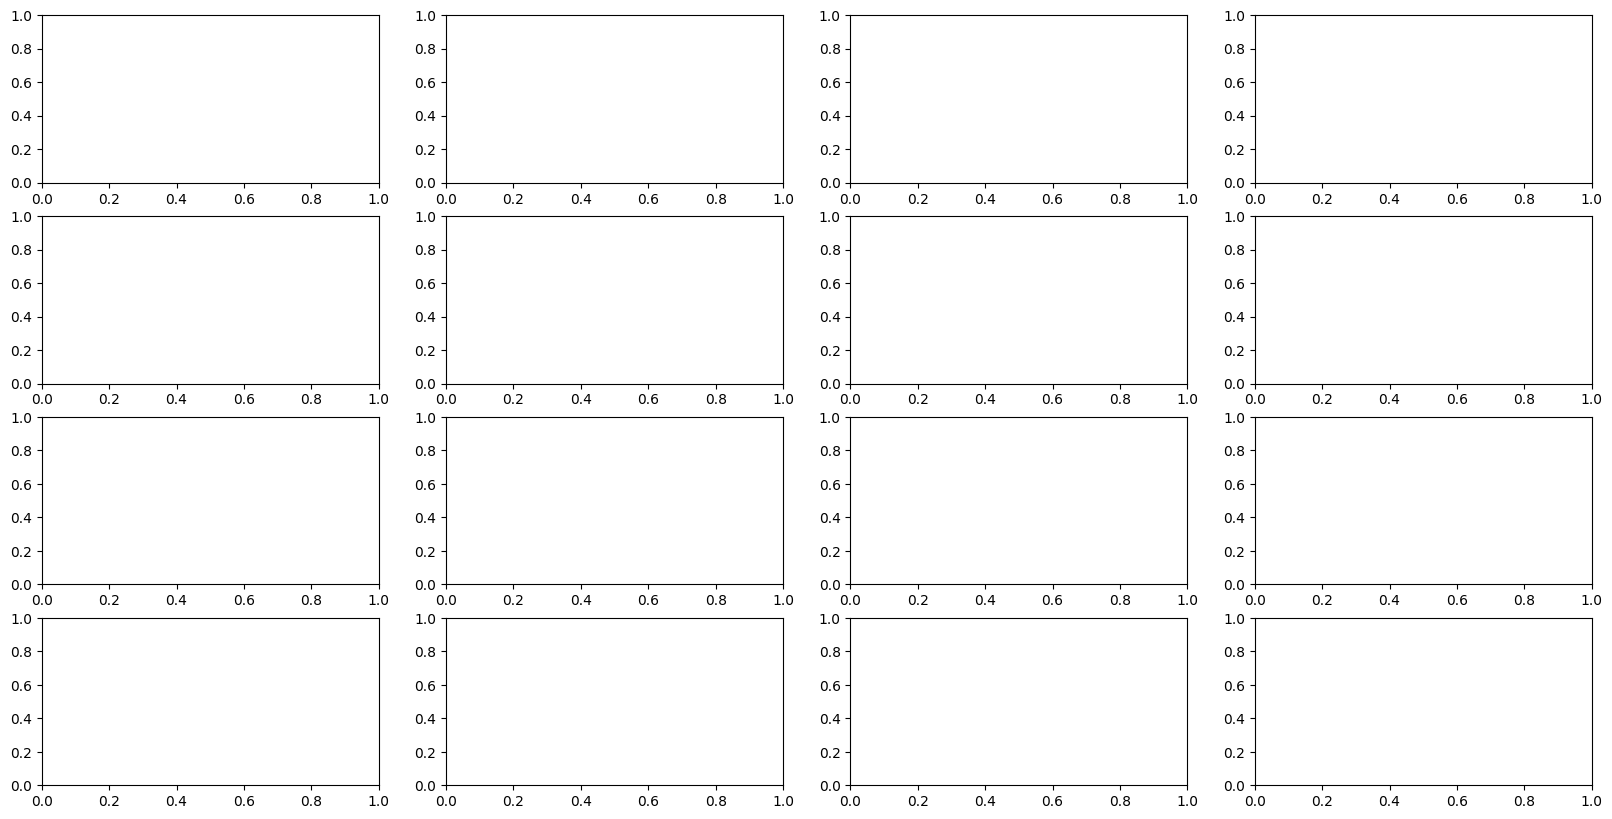

In [ ]:
from animation.util import backtransform_weights, reconstruct_image
from networks.mlp_models import MLP3D

ij_len = 4
# Plotting the tensors as heatmaps in grayscale
fig, axes = plt.subplots(ij_len, ij_len, figsize=(20, 10))

SOS = torch.Tensor([[0]]).long().to(device)

for i in range(ij_len):
    for j in range(ij_len):

        model.eval()
        novel_tokens = model.generate(SOS, 593, temperature=1.0, top_k=None)[:, 1:].unsqueeze(-1).to("cpu")
        novel_weights= vq.get_codes_from_indices((novel_tokens-1))

        dataset_no_transform = MnistNeFDataset(data_root_ours, **kwargs)
        original_dict = dataset_no_transform[0][0]

        reconstructed_dict = backtransform_weights(novel_weights, original_dict["state_dict"])

        mlp3d = MLP3D(**original_dict["model_config"])
        mlp3d.load_state_dict(reconstructed_dict)
        reconstructed_tensor = reconstruct_image(mlp3d)

        axes[i][j].imshow(reconstructed_tensor, cmap='gray', aspect='auto')

plt.show()

In [ ]:
pred, _ = model(X, Y)

In [ ]:
pred.size()

torch.Size([1, 593, 1024])

In [ ]:
torch.sum((pred.argmax(dim=-1)==Y).int())

tensor(2, device='cuda:0')